Data source: https://www.kaggle.com/datasets/mirichoi0218/insurance

The goal is to do some quick practice on data analysis.

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [43]:
df = pd.read_csv("data/insurance.csv")

display(df.head())
display(df.describe())
display(df.info())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

Ok, this seems to be a very simple dataset, and the first thing we're gonna do is some quick feature engineering

In [29]:
# checking # of categories in categorical variables and looking for NAs before we create dummies:
for column in ['sex', 'children', 'smoker', 'region']:
    display(df[column].value_counts(dropna=False))

male      676
female    662
Name: sex, dtype: int64

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

no     1064
yes     274
Name: smoker, dtype: int64

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [44]:
df['female'] = (df['sex'] == 'female').astype(int)
df['has_children'] = (df['children'] > 0).astype(int)
df['smoker'] = (df['smoker'] == 'yes').astype(int)

In [46]:
df.head()

,age,sex,bmi,children,smoker,region,charges,female,has_children
0,19,female,27.900,0,1,southwest,16884.92400,1,0
1,18,male,33.770,1,0,southeast,1725.55230,0,1
2,28,male,33.000,3,0,southeast,4449.46200,0,1
3,33,male,22.705,0,0,northwest,21984.47061,0,0
4,32,male,28.880,0,0,northwest,3866.85520,0,0


Before heading out to modeling, let's check the relationship between the variables:

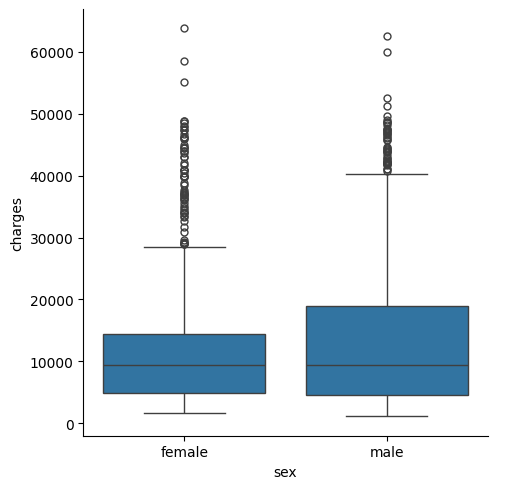

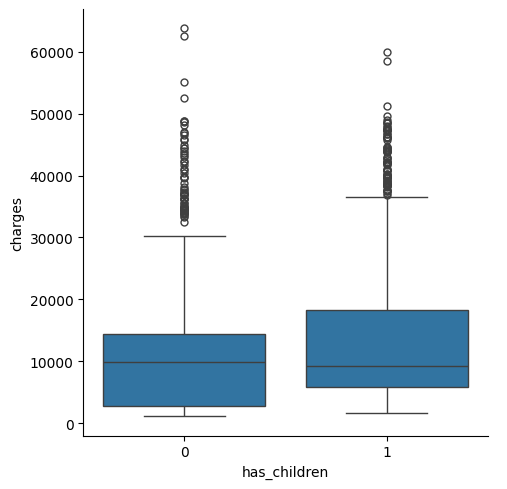

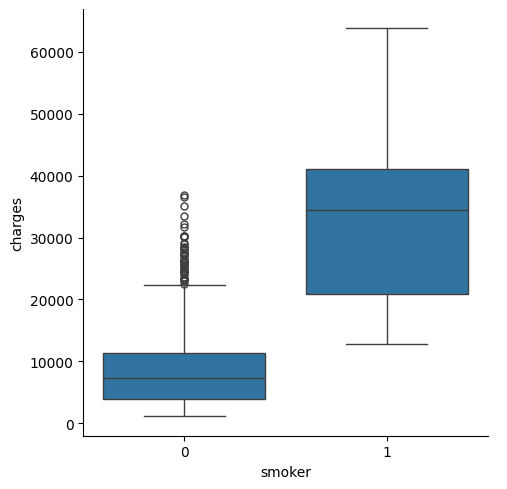

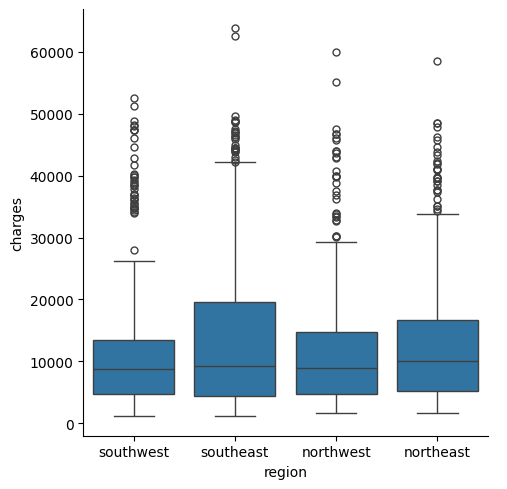

In [49]:
sns.catplot(data=df, x='sex', y='charges', kind='box')
sns.catplot(data=df, x='has_children', y='charges', kind='box')
sns.catplot(data=df, x='smoker', y='charges', kind='box')
sns.catplot(data=df, x='region', y='charges', kind='box')
sns.catplot(data=df, x='region', y='charges', kind='box')

Overall, there is a lot of outliers for all variables, but some key notes:
1) Men seems to be billed a little bit more than women, even though the median value is basically the same
2) Same logic for those with children
3) Smokers are charged way higher than non smokers
4) The median charge values seems to be pretty close for all regions, but the southeast and northeast regions do have a higher variation

Now, checking the relationship between the numerical variables, smoking seems to be a good predictor of higher charges:

<Axes: xlabel='age', ylabel='charges'>

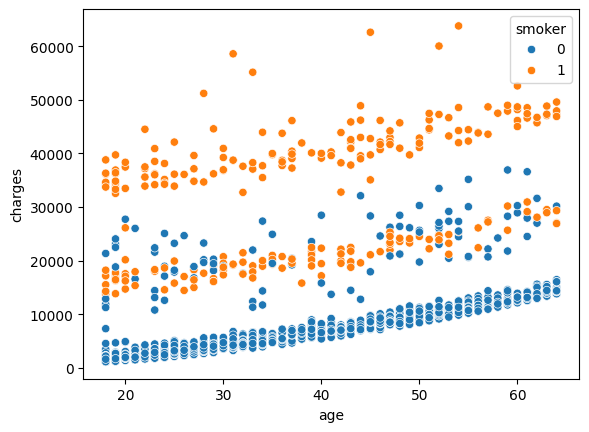

In [61]:
sns.scatterplot(data=df, x='age', y='charges', hue='smoker')

<Axes: xlabel='bmi', ylabel='charges'>

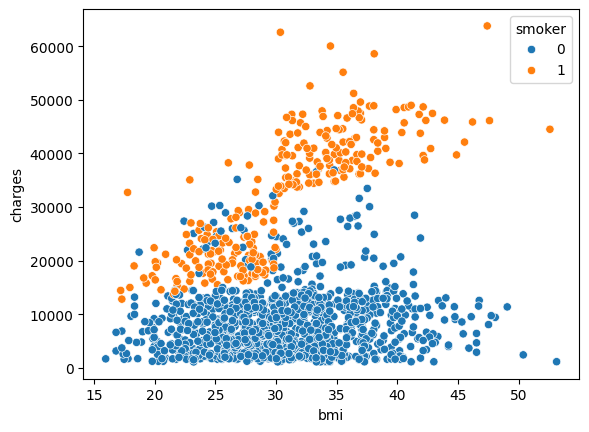

In [62]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker')

Diving deeper, there seems to be a cut-off for the smokers: if bmi (body mass index) is higher than 30, then the charges are higher.

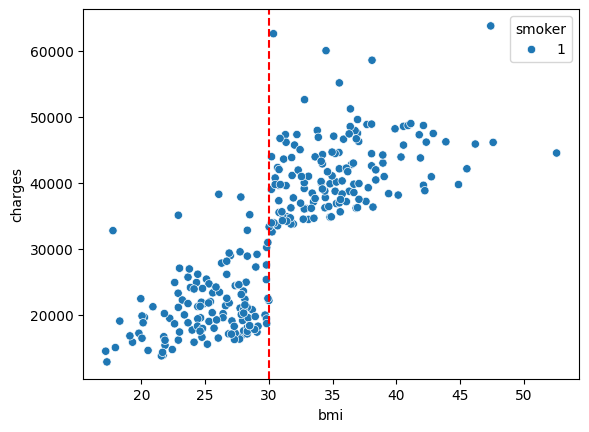

In [75]:
sns.scatterplot(data=df[df['smoker'] == 1], x='bmi', y='charges', hue='smoker')
plt.axvline(x=30, color='red', linestyle='--')

Checking out the classification of BMI values, accordingly to WHO, a BMI greater than 30 indicates Obesity class I.

This info reminds me of another variable that we can create, based on the BMI classification.

In [109]:
df['nutritional_status'] = pd.cut(
    df['bmi'],
    bins=[-np.inf, 18.5, 25, 30, 35, 40, np.inf],
    labels=['Underweight', 'Normal weight', 'Pre-obesity', 'Obesity class I', 'Obesity class II', 'Obesity class III'],
    right=False)

df['nutritional_status'].value_counts()


Obesity class I      391
Pre-obesity          386
Normal weight        225
Obesity class II     225
Obesity class III     91
Underweight           20
Name: nutritional_status, dtype: int64

<Axes: xlabel='charges', ylabel='nutritional_status'>

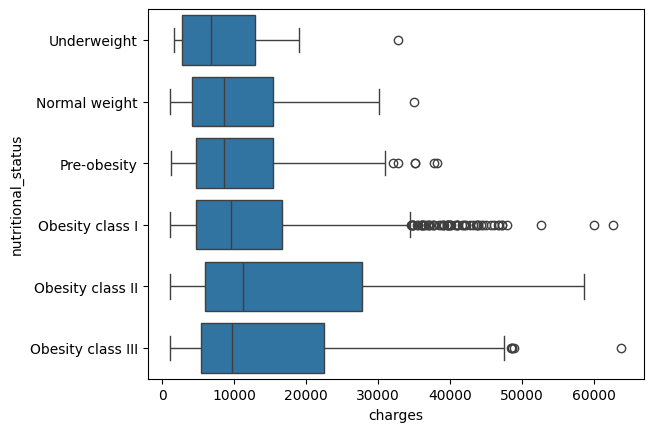

In [114]:
sns.boxplot(data=df, y='nutritional_status', x='charges')

In [108]:
df[df['nutritional_status'] != df['nutritional_status2']]

,age,sex,bmi,children,smoker,region,charges,female,has_children,nutritional_status,nutritional_status2
